# Scatterplot Louvain

In [13]:
from pandas                 import DataFrame as df
from databaseconnection     import DatabaseConnection
import pandas               as pd
import numpy                as np
import seaborn              as sns
import matplotlib.pyplot    as plt

gds = DatabaseConnection().get_database_connection()
gds.version()


'2.3.2'

In [14]:
respondents = gds.run_cypher("MATCH (r:Respondent) RETURN r")["r"]

# Convert the respondents Series to a DataFrame
respondents_data = []
for respondent in respondents:
    respondents_data.append({'id': respondent['id'], 'normalityIndex': respondent["normalityIndex"], 'louvainCommunity': respondent["louvainCommunity"]})

respondents_df = df(respondents_data)

## Scatterplot of the respondents.

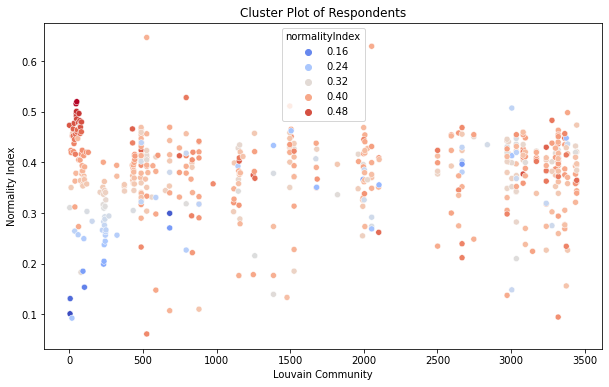

In [4]:
# Calculate the mean normalityIndex for each Louvain community
mean_normality_index = respondents_df.groupby('louvainCommunity')['normalityIndex'].mean()

# Add a new column to the DataFrame with the mean normalityIndex for each Louvain community
respondents_df['mean_normalityIndex'] = respondents_df['louvainCommunity'].apply(lambda x: mean_normality_index[x])

# Create the cluster plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=respondents_df, x="louvainCommunity", y="normalityIndex", hue=mean_normality_index, palette='coolwarm')
plt.xlabel("Louvain Community")
plt.ylabel("Normality Index")
plt.title("Cluster Plot of Respondents")
plt.show()

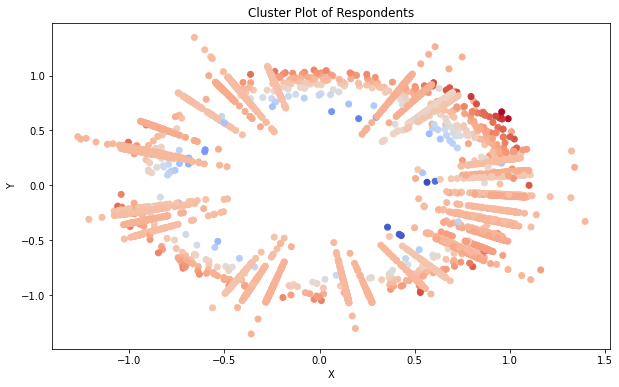

In [8]:
from sklearn.preprocessing import MinMaxScaler

# Calculate the mean normalityIndex for each Louvain community
mean_normality_index = respondents_df.groupby('louvainCommunity')['normalityIndex'].mean()

# Normalize the normalityIndex values to a suitable range
scaler = MinMaxScaler(feature_range=(0.5, 1.5))
respondents_df['normalized_normalityIndex'] = scaler.fit_transform(respondents_df[['normalityIndex']])

# Convert Louvain community and normalized normality index to 2D Cartesian coordinates
unique_communities = respondents_df['louvainCommunity'].nunique()
respondents_df['theta'] = respondents_df['louvainCommunity'].apply(lambda x: 2 * np.pi * x / unique_communities)
respondents_df['x'] = respondents_df['normalized_normalityIndex'] * np.cos(respondents_df['theta'])
respondents_df['y'] = respondents_df['normalized_normalityIndex'] * np.sin(respondents_df['theta'])

# Create the cluster plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(respondents_df['x'], respondents_df['y'], c=respondents_df['louvainCommunity'].apply(lambda x: mean_normality_index[x]), cmap='coolwarm')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Cluster Plot of Respondents")
plt.show()

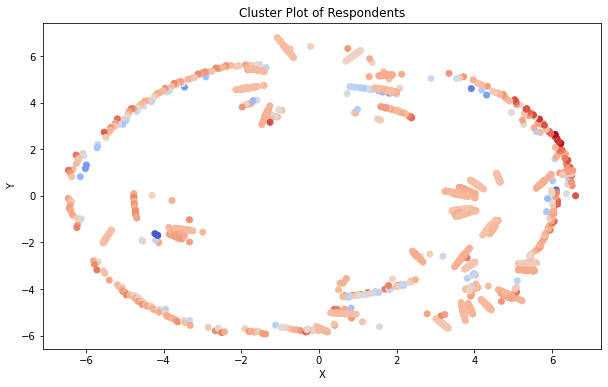

In [9]:
# Normalize the normalityIndex values to a suitable range
scaler = MinMaxScaler(feature_range=(1, 2))
respondents_df['normalized_normalityIndex'] = scaler.fit_transform(respondents_df[['normalityIndex']])

# Generate unique centroid coordinates for each Louvain community
unique_communities = respondents_df['louvainCommunity'].nunique()
theta = np.linspace(0, 2 * np.pi, unique_communities + 1)[:-1]  # Exclude the last value to prevent overlapping of the first and last centroids
centroid_radius = 5  # You can adjust this value to control the distance between the centroids and the origin
centroids = {community: (centroid_radius * np.cos(angle), centroid_radius * np.sin(angle)) for community, angle in zip(sorted(respondents_df['louvainCommunity'].unique()), theta)}

# Calculate the distance from the centroid for each respondent based on their normality index
respondents_df['x'] = respondents_df.apply(lambda row: centroids[row['louvainCommunity']][0] + row['normalized_normalityIndex'] * np.cos(row['louvainCommunity'] * 2 * np.pi / unique_communities), axis=1)
respondents_df['y'] = respondents_df.apply(lambda row: centroids[row['louvainCommunity']][1] + row['normalized_normalityIndex'] * np.sin(row['louvainCommunity'] * 2 * np.pi / unique_communities), axis=1)

# Create the cluster plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(respondents_df['x'], respondents_df['y'], c=respondents_df['louvainCommunity'].apply(lambda x: mean_normality_index[x]), cmap='coolwarm')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Cluster Plot of Respondents")
plt.show()

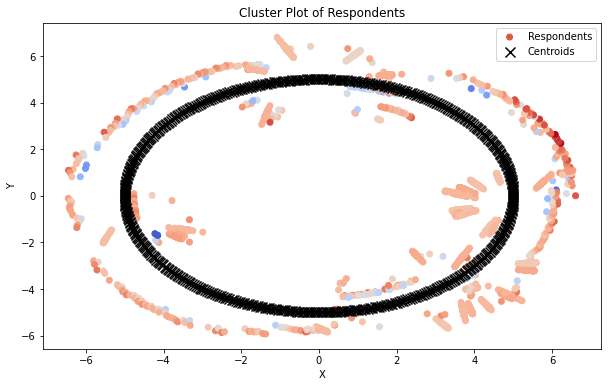

In [10]:
# Normalize the normalityIndex values to a suitable range
scaler = MinMaxScaler(feature_range=(1, 2))
respondents_df['normalized_normalityIndex'] = scaler.fit_transform(respondents_df[['normalityIndex']])

# Generate unique centroid coordinates for each Louvain community
unique_communities = respondents_df['louvainCommunity'].nunique()
theta = np.linspace(0, 2 * np.pi, unique_communities + 1)[:-1]
centroid_radius = 5
centroids = {community: (centroid_radius * np.cos(angle), centroid_radius * np.sin(angle)) for community, angle in zip(sorted(respondents_df['louvainCommunity'].unique()), theta)}

# Calculate the distance from the centroid for each respondent based on their normality index
respondents_df['x'] = respondents_df.apply(lambda row: centroids[row['louvainCommunity']][0] + row['normalized_normalityIndex'] * np.cos(row['louvainCommunity'] * 2 * np.pi / unique_communities), axis=1)
respondents_df['y'] = respondents_df.apply(lambda row: centroids[row['louvainCommunity']][1] + row['normalized_normalityIndex'] * np.sin(row['louvainCommunity'] * 2 * np.pi / unique_communities), axis=1)

# Create the cluster plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(respondents_df['x'], respondents_df['y'], c=respondents_df['louvainCommunity'].apply(lambda x: mean_normality_index[x]), cmap='coolwarm', label='Respondents')
centroid_x, centroid_y = zip(*centroids.values())
plt.scatter(centroid_x, centroid_y, c='black', marker='x', s=100, label='Centroids')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Cluster Plot of Respondents")
plt.legend()
plt.show()

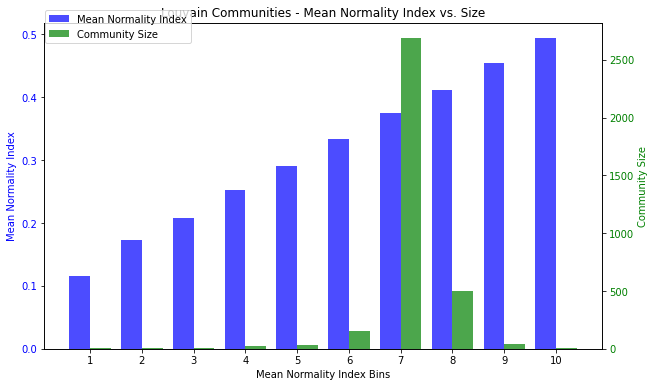

In [15]:
# Group by louvainCommunity and calculate mean, standard deviation, and size
community_stats = respondents_df.groupby('louvainCommunity').agg({'normalityIndex': ['mean', 'std', 'count']}).reset_index()
community_stats.columns = ['louvainCommunity', 'mean_normalityIndex', 'std_normalityIndex', 'size']

# Categorize Louvain communities into bins based on mean_normalityIndex
num_bins = 10  # You can adjust this value to control the number of bins
community_stats['mean_normalityIndex_bin'] = pd.cut(community_stats['mean_normalityIndex'], bins=num_bins, labels=np.arange(1, num_bins + 1))

# Calculate the aggregated size and mean_normalityIndex for each bin
binned_stats = community_stats.groupby('mean_normalityIndex_bin').agg({'size': 'sum', 'mean_normalityIndex': 'mean'}).reset_index()

# Create a grouped bar chart with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

width = 0.4
x = np.arange(len(binned_stats))

ax1.bar(x - width / 2, binned_stats['mean_normalityIndex'], width, label='Mean Normality Index', color='blue', alpha=0.7)
ax2.bar(x + width / 2, binned_stats['size'], width, label='Community Size', color='green', alpha=0.7)

ax1.set_xlabel('Mean Normality Index Bins')
ax1.set_ylabel('Mean Normality Index', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2.set_ylabel('Community Size', color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax1.set_xticks(x)
ax1.set_xticklabels(binned_stats['mean_normalityIndex_bin'])

plt.title("Louvain Communities - Mean Normality Index vs. Size")
fig.legend(loc="upper left", bbox_to_anchor=(0.12, 0.92))
plt.show()

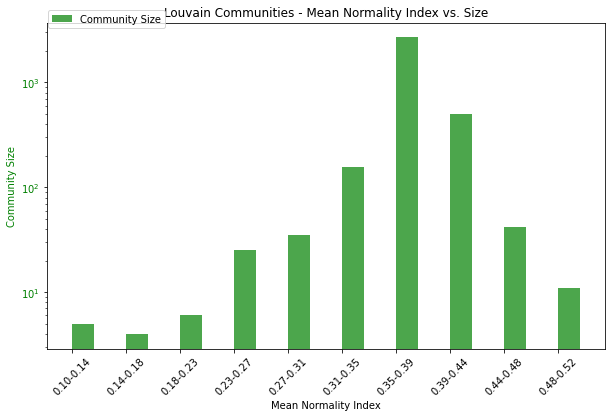

In [24]:
# Group by louvainCommunity and calculate mean, standard deviation, and size
community_stats = respondents_df.groupby('louvainCommunity').agg({'normalityIndex': ['mean', 'std', 'count']}).reset_index()
community_stats.columns = ['louvainCommunity', 'mean_normalityIndex', 'std_normalityIndex', 'size']

# Categorize Louvain communities into bins based on mean_normalityIndex
num_bins = 10  # You can adjust this value to control the number of bins
community_stats['mean_normalityIndex_bin'], bin_intervals = pd.cut(community_stats['mean_normalityIndex'], bins=num_bins, labels=False, retbins=True)
community_stats['mean_normalityIndex_bin'] += 1

# Calculate the aggregated size and mean_normalityIndex for each bin
binned_stats = community_stats.groupby('mean_normalityIndex_bin').agg({'size': 'sum', 'mean_normalityIndex': 'mean'}).reset_index()

# Create a grouped bar chart with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

width = 0.4
x = np.arange(len(binned_stats))

ax1.bar(x + width / 2, binned_stats['size'], width, label='Community Size', color='green', alpha=0.7)

ax1.set_xlabel('Mean Normality Index')
ax1.set_ylabel('Community Size', color='green')
ax1.tick_params(axis='y', labelcolor='green')

bin_labels = [f"{bin_intervals[i]:.2f}-{bin_intervals[i + 1]:.2f}" for i in range(num_bins)]
ax1.set_xticks(x)
ax1.set_xticklabels(bin_labels, rotation=45)

ax1.set_yscale('log')

plt.title("Louvain Communities - Mean Normality Index vs. Size")
plt.show()